In [47]:
import wandb
wandb.login()

True

In [48]:
from wandb import Api
import pandas as pd
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

api = Api(timeout=120)

ENTITY  = "hp-learning-rules"
PROJECT = "sweep-task-gpt2-grid"
PATH    = f"{ENTITY}/{PROJECT}"

In [49]:
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"state": "finished"}, order="-created_at")

run = runs[0]

hist = pd.DataFrame(list(run.scan_history()))

print(hist.columns.tolist())

print(hist)

['_timestamp', 'trainer/global_step', 'epoch', 'test/loss', 'train/acc_step', 'train/loss_step', '_step', 'val/acc_best', 'train/loss_epoch', 'test/acc', 'train/acc_epoch', 'val/acc', '_runtime', 'val/loss']
        _timestamp  trainer/global_step  epoch test/loss  train/acc_step  \
0     1.755069e+09                   49      0      None             0.0   
1     1.755069e+09                   99      0      None             0.0   
2     1.755069e+09                  149      0      None             0.0   
3     1.755069e+09                  199      0      None             0.0   
4     1.755069e+09                  249      0      None             0.0   
...            ...                  ...    ...       ...             ...   
5991  1.755069e+09                 6259     19      None             NaN   
5992  1.755069e+09                 6259     19      None             NaN   
5993  1.755069e+09                 6260     20      None             NaN   
5994  1.755069e+09              

In [50]:

rows = []
for r in runs:
    cfg = r.config or {}
    summ = r.summary or {}
    
    # Access nested optimizer config
    optimizer_cfg = cfg.get("model", {}).get("optimizer", {})
    
    rows.append({
        "run_id": r.id,
        "name": r.name,
        "update_alg": optimizer_cfg.get("update_alg", "unknown"),
        "momentum": optimizer_cfg.get("momentum", 0.0),
        "alpha": optimizer_cfg.get("alpha", 0.0),
        "block_size": optimizer_cfg.get("block_size", 0),
        "lr": optimizer_cfg.get("lr", "unknown"),
        "weight_decay": optimizer_cfg.get("weight_decay", 0.0),
        "nesterov": optimizer_cfg.get("nesterov", False),
        "dataset": cfg.get("dataset", "unknown"),
        "seed": cfg.get("seed", "unknown"),
        # Get test accuracy (seems to be your main metric)
        "test_acc": summ.get("test/acc"),
        "val_acc": summ.get("val/acc"),
        "train_acc": summ.get("train/acc_epoch"),
        "url": r.url,
    })

runs_df = pd.DataFrame(rows)

# Create optimizer categories based on update_alg and momentum
def categorize_optimizer(row):
    alg = row["update_alg"]
    mom = row["momentum"]
    
    if alg == "gd":
        return "SGD+Momentum" if mom > 0 else "SGD"
    elif alg == "md":
        return "MD+Momentum" if mom > 0 else "MD"
    else:
        return f"{alg}_{mom}"

runs_df["opt_category"] = runs_df.apply(categorize_optimizer, axis=1)

# Use test accuracy as main metric
runs_df["acc"] = runs_df["test_acc"]

# Filter out runs with missing accuracy
runs_df_clean = runs_df.dropna(subset=["acc"]).copy()

print("Available optimizer categories:")
print(runs_df_clean["opt_category"].value_counts())
print(f"\nTotal runs with test accuracy: {len(runs_df_clean)}")
print(f"Accuracy range: {runs_df_clean['acc'].min():.4f} - {runs_df_clean['acc'].max():.4f}")

Available optimizer categories:
opt_category
MD+Momentum     260
SGD+Momentum    167
MD               79
SGD              57
Name: count, dtype: int64

Total runs with test accuracy: 563
Accuracy range: 0.0000 - 0.6922


In [51]:
# Setup plotting style
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150
})

# Define colors
colors = {
    'SGD': '#1f77b4',  # Blue
    'MD': '#ff7f0e',   # Orange
    'MNIST': '#2ca02c', # Green
    'Fashion': '#d62728' # Red
}

print("✅ Setup complete!")

# Load data from WandB
api = Api(timeout=120)
ENTITY = "hp-learning-rules"

def load_clean_data(project_name):
    """Load and clean WandB data"""
    print(f"Loading {project_name}...")
    runs = api.runs(f"{ENTITY}/{project_name}", filters={"state": "finished"})
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'name': run.name}
        
        # Add config data
        if run.config:
            for key, value in run.config.items():
                row[f'config_{key}'] = value
                
        # Add summary data
        if run.summary:
            for key, value in run.summary.items():
                row[f'summary_{key}'] = value
                
        data.append(row)
    
    df = pd.DataFrame(data)
    
    # Clean and standardize optimizer names
    if 'config_optimizer.update' in df.columns:
        df['optimizer'] = df['config_optimizer.update'].str.upper().replace({'GD': 'SGD'})
    
    print(f"  ✅ Loaded {len(df)} runs")
    return df

# Load datasets
mnist_df = load_clean_data("big-mnist")
fashion_df = load_clean_data("big-fashion_mnist")

# Add dataset labels
mnist_df['dataset'] = 'MNIST'
fashion_df['dataset'] = 'Fashion-MNIST'

print(f"\n📊 Data loaded successfully!")
print(f"MNIST: {len(mnist_df)} runs, Fashion-MNIST: {len(fashion_df)} runs")

✅ Setup complete!
Loading big-mnist...
  ✅ Loaded 296 runs
Loading big-fashion_mnist...
  ✅ Loaded 296 runs

📊 Data loaded successfully!
MNIST: 296 runs, Fashion-MNIST: 296 runs


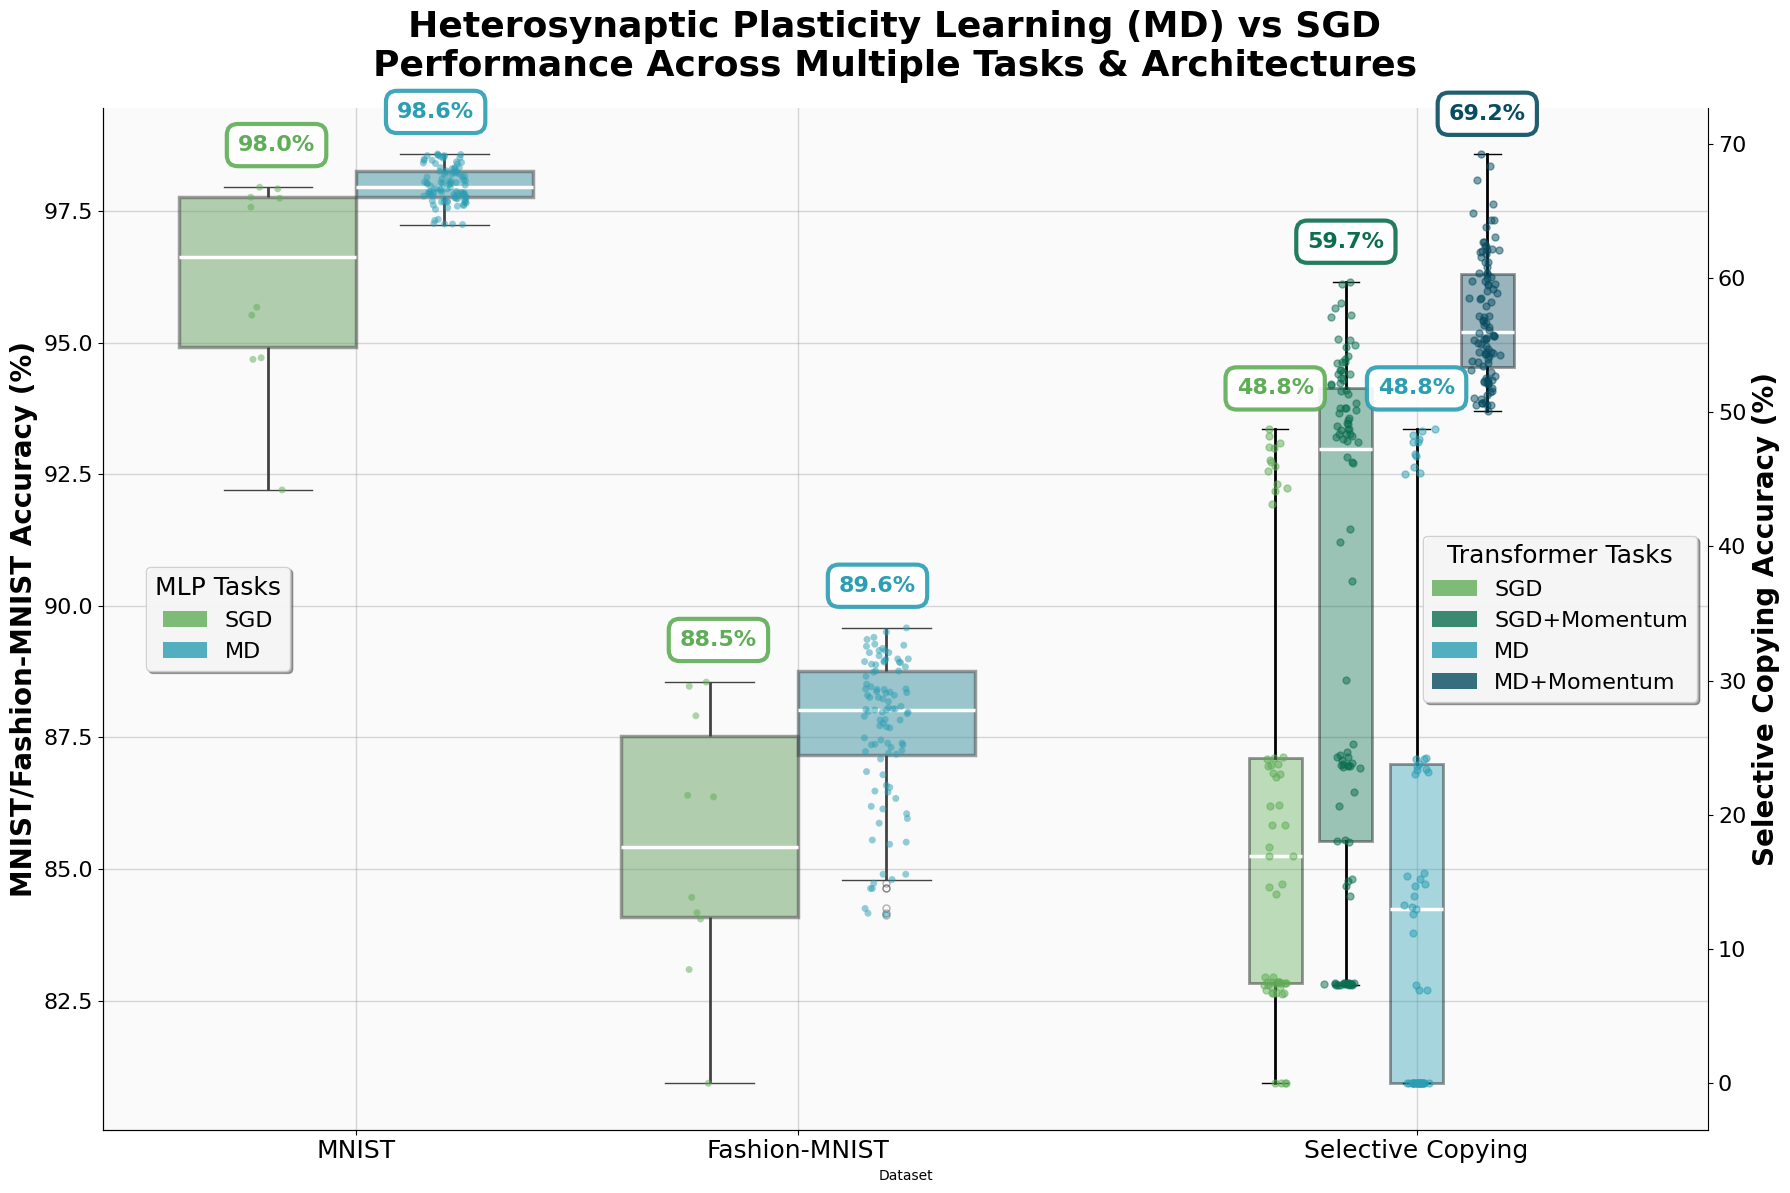

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('default')

# --- helpers ---
def to_percent(series):
    """Scale to 0–100 exactly once."""
    s = pd.Series(series).dropna()
    if s.empty:
        return pd.Series(series)
    m = s.mean()
    # if already in [0,100], return as-is; if in [0,1], scale by 100
    if m > 1.5:   # heuristic threshold
        return pd.Series(series)
    return pd.Series(series) * 100

def get_top_n(df, optimizer, n=10, col="summary_test_accuracy"):
    return df[df['config_optimizer.update'] == optimizer][col].nlargest(n)

def get_copying_data(df, category, n=100):
    return df[df['opt_category'] == category]['acc'].nlargest(n)

# --- data selection (unchanged) ---
sgd_mnist_top10    = get_top_n(mnist_df,  'gd', 10)
md_mnist_top100    = get_top_n(mnist_df,  'md', 100)
sgd_fashion_top10  = get_top_n(fashion_df,'gd', 10)
md_fashion_top100  = get_top_n(fashion_df,'md', 100)

sgd_copying         = get_copying_data(runs_df_clean, 'SGD',            57)
sgd_momentum_copying= get_copying_data(runs_df_clean, 'SGD+Momentum',  100)
md_copying          = get_copying_data(runs_df_clean, 'MD',             57)
md_momentum_copying = get_copying_data(runs_df_clean, 'MD+Momentum',   100)

# --- build plotting frames with correct scaling ---
plot_data_main = []
for acc in to_percent(sgd_mnist_top10):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'SGD', 'Dataset': 'MNIST'})
for acc in to_percent(md_mnist_top100):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'MD', 'Dataset': 'MNIST'})
for acc in to_percent(sgd_fashion_top10):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'SGD', 'Dataset': 'Fashion-MNIST'})
for acc in to_percent(md_fashion_top100):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'MD', 'Dataset': 'Fashion-MNIST'})

plot_data_copying = []
# copying 'acc' is in [0,1] → convert to %
for acc in to_percent(sgd_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'SGD',      'Dataset': 'Sel-Copying'})
for acc in to_percent(sgd_momentum_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'SGD+Mom',  'Dataset': 'Sel-Copying'})
for acc in to_percent(md_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'MD',       'Dataset': 'Sel-Copying'})
for acc in to_percent(md_momentum_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'MD+Mom',   'Dataset': 'Sel-Copying'})

df_main = pd.DataFrame(plot_data_main)
df_copying = pd.DataFrame(plot_data_copying)

# --- colors (unchanged) ---
colors = {
    'SGD':     '#5fad56',
    'MD':      '#2b9eb3',
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  '#084c61'
}

fig, ax1 = plt.subplots(figsize=(18, 12))
fig.patch.set_facecolor('white')

box_props     = dict(linewidth=2.5, alpha=0.8)
whisker_props = dict(linewidth=2.5)
median_props  = dict(linewidth=3, color='white')
flier_props   = dict(marker='o', markerfacecolor='gray', alpha=0.6, markersize=6)

# left (vision) boxplot
main_palette = {'SGD': colors['SGD'], 'MD': colors['MD']}
# For seaborn boxplots
sns.boxplot(
    data=df_main, x='Dataset', y='Accuracy', hue='Optimizer',
    palette=main_palette, ax=ax1,
    boxprops=dict(linewidth=2.5, alpha=0.5),   # lower alpha
    whiskerprops=dict(linewidth=2.0),
    medianprops=dict(linewidth=2.5, color='white'),
    flierprops=dict(marker='o', alpha=0.4, markersize=5)
)
# strip without second legend
sns.stripplot(
    data=df_main, x='Dataset', y='Accuracy', hue='Optimizer',
    palette=main_palette, size=5, alpha=0.5, dodge=True, ax=ax1, legend=False
)

# right axis (selective copying)
ax2 = ax1.twinx()
copying_positions = [2.08, 2.24, 2.40, 2.56]  # a touch tighter so legend fits
copying_colors = [colors['SGD'], colors['SGD+Mom'], colors['MD'], colors['MD+Mom']]

for i, optimizer in enumerate(['SGD', 'SGD+Mom', 'MD', 'MD+Mom']):
    data = df_copying[df_copying['Optimizer'] == optimizer]['Accuracy'].values
    if data.size:
        ax2.boxplot(
            [data], positions=[copying_positions[i]], widths=0.12,
            patch_artist=True,
            boxprops=dict(facecolor=copying_colors[i], alpha=0.4, linewidth=2.0),  # alpha=0.4
            whiskerprops=dict(linewidth=2.0),
            medianprops=dict(linewidth=2.5, color='white'),
            flierprops=dict(marker='o', alpha=0.3, markersize=5)
        )
        # FIX jitter: numeric center + noise
        jitter = np.random.normal(0, 0.015, data.size)
        ax2.scatter(np.full(data.size, copying_positions[i]) + jitter, data,
                    color=copying_colors[i], alpha=0.5, s=25, zorder=3)

# labels
ax1.set_ylabel('MNIST/Fashion-MNIST Accuracy (%)', fontsize=20, fontweight='bold', color='black')
ax2.set_ylabel('Selective Copying Accuracy (%)',   fontsize=20, fontweight='bold', color='black')
# ax1.set_xlabel('Dataset', fontsize=20, fontweight='bold', color='black')

ax1.tick_params(labelsize=16, colors='black', which='both')
ax2.tick_params(labelsize=16, colors='black', which='both')
ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=1)
ax1.set_facecolor('#fafafa')

# spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# x labels
ax1.set_xticks([0, 1, 2.4])
ax1.set_xticklabels(['MNIST', 'Fashion-MNIST', 'Selective Copying'], fontsize=18)

# legends
# handles1, labels1 = ax1.get_legend_handles_labels()


vision_handles = [
    plt.Rectangle((0,0),1,1, facecolor=colors['SGD'], alpha=0.8),
    plt.Rectangle((0,0),1,1, facecolor=colors['MD'],  alpha=0.8)
]
legend1 = ax1.legend(
    vision_handles, ['SGD', 'MD'],
    title='MLP Tasks',
    loc='center left', bbox_to_anchor=(0.02, 0.5),
    frameon=True, fancybox=True, shadow=True,
    fontsize=16, title_fontsize=18
)
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_alpha(0.9)

# legend1 = ax1.legend(handles1[:2], labels1[:2], title='MNIST Tasks',
#                      loc='center left', bbox_to_anchor=(0.005, 0.5),
#                      frameon=True, fancybox=True, shadow=True,
#                      fontsize=16, title_fontsize=18)
# legend1.get_frame().set_facecolor('white'); legend1.get_frame().set_alpha(0.9)

copying_handles = [plt.Rectangle((0,0),1,1, facecolor=colors[opt], alpha=0.8)
                   for opt in ['SGD', 'SGD+Mom', 'MD', 'MD+Mom']]
legend2 = ax2.legend(copying_handles,
                     ['SGD', 'SGD+Momentum', 'MD', 'MD+Momentum'],
                     title='Transformer Tasks', loc='center right',
                     bbox_to_anchor=(0.9999, 0.5),
                     frameon=True, fancybox=True, shadow=True,
                     fontsize=16, title_fontsize=18)
legend2.get_frame().set_facecolor('white'); legend2.get_frame().set_alpha(0.9)

# title: higher + more top margin
fig.suptitle('Heterosynaptic Plasticity Learning (MD) vs SGD\nPerformance Across Multiple Tasks & Architectures',
             fontsize=26, fontweight='bold', y=0.99, color='black')
plt.subplots_adjust(top=0.86)  # extra headroom so annotations never hit the title

# annotations
def add_perf_box(ax, x_pos, y_pos, value, color, fontsize=16):
    bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white',
                      edgecolor=color, linewidth=3, alpha=0.9)
    ax.text(x_pos, y_pos, f'{value:.1f}%', ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color=color, bbox=bbox_props)

# main annotations (auto-placed a bit above the max point)
positions_main = {'MNIST': {'SGD': -0.18, 'MD': 0.18},
                  'Fashion-MNIST': {'SGD': 0.82,  'MD': 1.18}}

main_stats = []
for dataset in ['MNIST', 'Fashion-MNIST']:
    for optimizer in ['SGD', 'MD']:
        subset = df_main[(df_main['Dataset'] == dataset) & (df_main['Optimizer'] == optimizer)]
        if len(subset):
            best = subset['Accuracy'].max()
            y_pos = best + 0.8  # smaller offset now that scale is fixed
            add_perf_box(ax1, positions_main[dataset][optimizer], y_pos, best, colors[optimizer])
            main_stats.append({'dataset': dataset, 'optimizer': optimizer, 'best': best})

# selective copying annotations
for i, optimizer in enumerate(['SGD', 'SGD+Mom', 'MD', 'MD+Mom']):
    data = df_copying[df_copying['Optimizer'] == optimizer]['Accuracy']
    if len(data):
        best = data.max()
        y_pos = best + 3.0
        add_perf_box(ax2, copying_positions[i], y_pos, best, colors[optimizer])

plt.tight_layout()
plt.show()



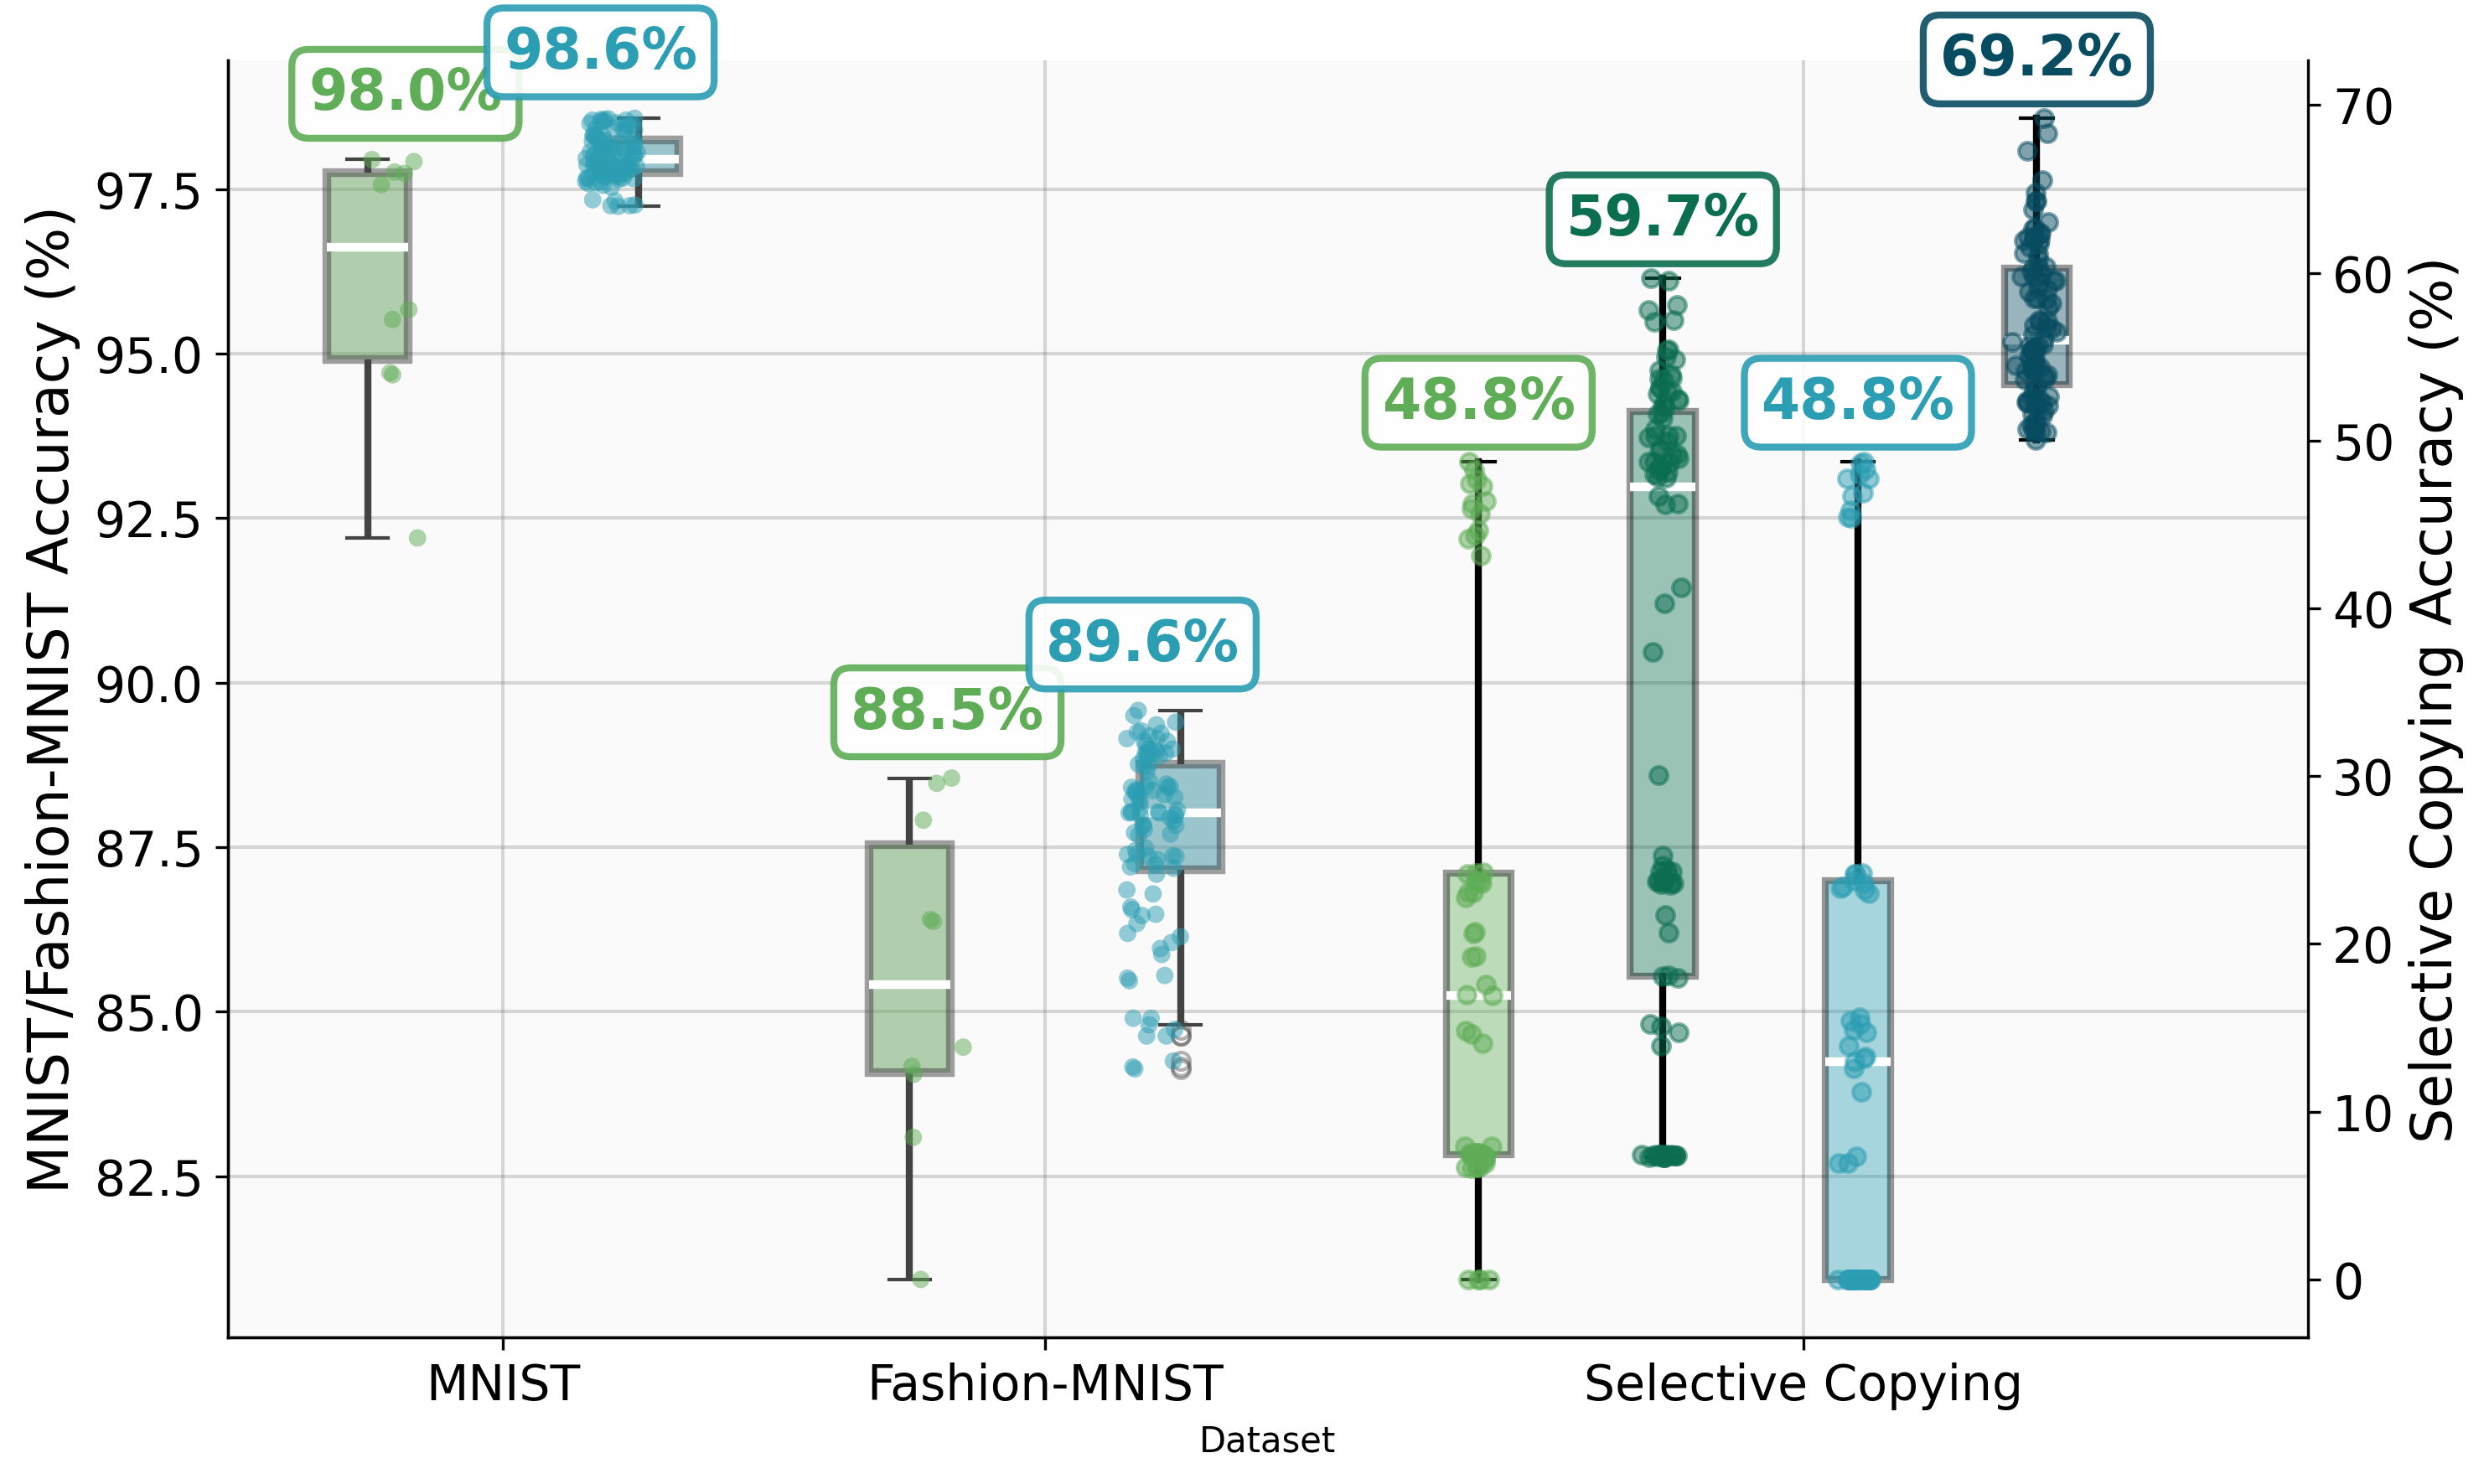

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('default')

# --- helpers ---
def to_percent(series):
    """Scale to 0–100 exactly once."""
    s = pd.Series(series).dropna()
    if s.empty:
        return pd.Series(series)
    m = s.mean()
    # if already in [0,100], return as-is; if in [0,1], scale by 100
    if m > 1.5:   # heuristic threshold
        return pd.Series(series)
    return pd.Series(series) * 100

def get_top_n(df, optimizer, n=10, col="summary_test_accuracy"):
    return df[df['config_optimizer.update'] == optimizer][col].nlargest(n)

def get_copying_data(df, category, n=100):
    return df[df['opt_category'] == category]['acc'].nlargest(n)

# --- data selection (unchanged) ---
sgd_mnist_top10    = get_top_n(mnist_df,  'gd', 10)
md_mnist_top100    = get_top_n(mnist_df,  'md', 100)
sgd_fashion_top10  = get_top_n(fashion_df,'gd', 10)
md_fashion_top100  = get_top_n(fashion_df,'md', 100)

sgd_copying         = get_copying_data(runs_df_clean, 'SGD',            57)
sgd_momentum_copying= get_copying_data(runs_df_clean, 'SGD+Momentum',  100)
md_copying          = get_copying_data(runs_df_clean, 'MD',             57)
md_momentum_copying = get_copying_data(runs_df_clean, 'MD+Momentum',   100)

# --- build plotting frames with correct scaling ---
plot_data_main = []
for acc in to_percent(sgd_mnist_top10):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'SGD', 'Dataset': 'MNIST'})
for acc in to_percent(md_mnist_top100):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'MD', 'Dataset': 'MNIST'})
for acc in to_percent(sgd_fashion_top10):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'SGD', 'Dataset': 'Fashion-MNIST'})
for acc in to_percent(md_fashion_top100):
    plot_data_main.append({'Accuracy': acc, 'Optimizer': 'MD', 'Dataset': 'Fashion-MNIST'})

plot_data_copying = []
# copying 'acc' is in [0,1] → convert to %
for acc in to_percent(sgd_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'SGD',      'Dataset': 'Sel-Copying'})
for acc in to_percent(sgd_momentum_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'SGD+Mom',  'Dataset': 'Sel-Copying'})
for acc in to_percent(md_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'MD',       'Dataset': 'Sel-Copying'})
for acc in to_percent(md_momentum_copying):
    plot_data_copying.append({'Accuracy': acc, 'Optimizer': 'MD+Mom',   'Dataset': 'Sel-Copying'})

df_main = pd.DataFrame(plot_data_main)
df_copying = pd.DataFrame(plot_data_copying)

# --- colors (unchanged) ---
colors = {
    'SGD':     '#5fad56',
    'MD':      '#2b9eb3',
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  '#084c61'
}

# KEY CHANGE: Smaller figsize + high DPI for better text readability
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)  # Much smaller figure, high DPI
fig.patch.set_facecolor('white')

box_props     = dict(linewidth=2.5, alpha=0.8)
whisker_props = dict(linewidth=2.5)
median_props  = dict(linewidth=3, color='white')
flier_props   = dict(marker='o', markerfacecolor='gray', alpha=0.6, markersize=6)

# left (vision) boxplot
main_palette = {'SGD': colors['SGD'], 'MD': colors['MD']}
# For seaborn boxplots
sns.boxplot(
    width=1.0,
    gap=0.7,
    legend=False,
    data=df_main, x='Dataset', y='Accuracy', hue='Optimizer',
    palette=main_palette, ax=ax1,
    boxprops=dict(linewidth=2.5, alpha=0.5),   # lower alpha
    whiskerprops=dict(linewidth=2.0),
    medianprops=dict(linewidth=2.5, color='white'),
    flierprops=dict(marker='o', alpha=0.4, markersize=5),
)
# strip without second legend
sns.stripplot(
    data=df_main, x='Dataset', y='Accuracy', hue='Optimizer',
    palette=main_palette, size=5, alpha=0.5, dodge=True, ax=ax1, legend=False
)

# right axis (selective copying)
ax2 = ax1.twinx()
copying_positions = [1.8, 2.14, 2.50, 2.83]  # a touch tighter so legend fits
copying_colors = [colors['SGD'], colors['SGD+Mom'], colors['MD'], colors['MD+Mom']]

for i, optimizer in enumerate(['SGD', 'SGD+Mom', 'MD', 'MD+Mom']):
    data = df_copying[df_copying['Optimizer'] == optimizer]['Accuracy'].values
    if data.size:
        ax2.boxplot(
            [data], positions=[copying_positions[i]], widths=0.12,
            patch_artist=True,
            boxprops=dict(facecolor=copying_colors[i], alpha=0.4, linewidth=2.0),  # alpha=0.4
            whiskerprops=dict(linewidth=2.0),
            medianprops=dict(linewidth=2.5, color='white'),
            flierprops=dict(marker='o', alpha=0.3, markersize=5)
        )
        # FIX jitter: numeric center + noise
        jitter = np.random.normal(0, 0.015, data.size)
        ax2.scatter(np.full(data.size, copying_positions[i]) + jitter, data,
                    color=copying_colors[i], alpha=0.5, s=25, zorder=3)

# labels - INCREASED FONT SIZES for better readability
ax1.set_ylabel('MNIST/Fashion-MNIST Accuracy (%)', fontsize=16, color='black')
ax2.set_ylabel('Selective Copying Accuracy (%)',   fontsize=16, color='black')

# INCREASED tick label sizes
ax1.tick_params(labelsize=14, colors='black', which='both')
ax2.tick_params(labelsize=14, colors='black', which='both')
ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=1)
ax1.set_facecolor('#fafafa')

# spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# x labels - INCREASED font size
ax1.set_xticks([0, 1, 2.4])
ax1.set_xticklabels(['MNIST', 'Fashion-MNIST', 'Selective Copying'], fontsize=14)


# legends - INCREASED font sizes
# vision_handles = [
#     plt.Rectangle((0,0),1,1, facecolor=colors['SGD'], alpha=0.8),
#     plt.Rectangle((0,0),1,1, facecolor=colors['MD'],  alpha=0.8)
# ]
# legend1 = ax1.legend(
#     vision_handles, ['SGD', 'MD'],
#     title='MLP Tasks',
#     loc='center left', bbox_to_anchor=(0.02, 0.5),
#     frameon=True, fancybox=True, shadow=True,
#     fontsize=12, title_fontsize=14  # Increased legend font sizes
# )
# legend1.get_frame().set_facecolor('white')
# legend1.get_frame().set_alpha(0.9)

copying_handles = [plt.Rectangle((0,0),1,1, facecolor=colors[opt], alpha=0.8)
                   for opt in ['SGD', 'SGD+Mom', 'MD', 'MD+Mom']]
# legend2 = ax2.legend(copying_handles,
#                      ['SGD', 'SGD+Momentum', 'MD', 'MD+Momentum'],
#                      title='Transformer Tasks', loc='center right',
#                      bbox_to_anchor=(0.9999, 0.5),
#                      frameon=True, fancybox=True, shadow=True,
#                      fontsize=12, title_fontsize=14)  # Increased legend font sizes
# legend2.get_frame().set_facecolor('white'); legend2.get_frame().set_alpha(0.9)

# title: INCREASED font size
# fig.suptitle('Heterosynaptic Plasticity Learning (MD) vs SGD\nPerformance Across Multiple Tasks & Architectures',
#              fontsize=18, fontweight='bold', y=0.95, color='black')  # Reduced from 26 to 18, adjusted y
plt.subplots_adjust(top=0.82)  # Adjusted for smaller figure

# annotations - ADJUSTED for smaller figure
def add_perf_box(ax, x_pos, y_pos, value, color, fontsize=16):  # Reduced from 16 to 12
    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white',  # Reduced padding
                      edgecolor=color, linewidth=2, alpha=0.9)  # Reduced linewidth
    ax.text(x_pos, y_pos, f'{value:.1f}%', ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color=color, bbox=bbox_props)

# main annotations (auto-placed a bit above the max point)
positions_main = {'MNIST': {'SGD': -0.18, 'MD': 0.18},
                  'Fashion-MNIST': {'SGD': 0.82,  'MD': 1.18}}

main_stats = []
for dataset in ['MNIST', 'Fashion-MNIST']:
    for optimizer in ['SGD', 'MD']:
        subset = df_main[(df_main['Dataset'] == dataset) & (df_main['Optimizer'] == optimizer)]
        if len(subset):
            best = subset['Accuracy'].max()
            y_pos = best + 1.0  # Reduced offset for smaller figure
            add_perf_box(ax1, positions_main[dataset][optimizer], y_pos, best, colors[optimizer])
            main_stats.append({'dataset': dataset, 'optimizer': optimizer, 'best': best})

# selective copying annotations
for i, optimizer in enumerate(['SGD', 'SGD+Mom', 'MD', 'MD+Mom']):
    data = df_copying[df_copying['Optimizer'] == optimizer]['Accuracy']
    if len(data):
        best = data.max()
        y_pos = best + 3.5  # Reduced offset for smaller figure
        add_perf_box(ax2, copying_positions[i], y_pos, best, colors[optimizer])

plt.tight_layout()
plt.show()